In [1]:
import glob,os
from tqdm import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem,RDLogger
from tqdm import tqdm
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from catemb.data import CatDataset
RDLogger.DisableLog('rdApp.*')
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400
pt = Chem.GetPeriodicTable()
random_seed = 42

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def process_data(smiles_lst,process_blk=False):
    dataset = []
    split_smiles = []
    for smiles in tqdm(smiles_lst):
        try:
            if '.' in smiles:
                if process_blk:
                    smi_blks = sorted(smiles.split('.'),key=lambda x:len(x))
                    lig_blk = smi_blks[-1]
                    
                    split_smiles.append(smiles)
                    smiles = lig_blk
                    print(f'ligand block: {smiles}')
                else:
                    split_smiles.append(smiles)
                    continue
            
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
            if mol.GetNumAtoms() == 1:
                continue
            #mol_H = AllChem.AddHs(mol)
            #flag = AllChem.EmbedMolecule(mol_H, randomSeed=random_seed)
            #if flag != 0:
            #    continue
            #pos = mol_H.GetConformer().GetPositions()
            #atoms = [atom.GetAtomicNum() for atom in mol_H.GetAtoms()]
            data = {'smiles':Chem.MolToSmiles(mol)}
            dataset.append(data)
        except:
            pass
    return dataset, split_smiles

def link_lig_to_metal(lig_mol,metal_type,coord_at_idx_lst):
    rw_lig_mol = Chem.RWMol(lig_mol)
    rw_lig_mol.UpdatePropertyCache(strict=False)
    metal_idx = rw_lig_mol.AddAtom(Chem.Atom(metal_type))
    for at_idx in coord_at_idx_lst:
        rw_lig_mol.AddBond(at_idx,metal_idx,Chem.BondType.DATIVE)
    rw_lig_mol.UpdatePropertyCache(strict=True)
    cat_mol = rw_lig_mol.GetMol()
    return cat_mol

In [3]:
dataset = CatDataset(root='../dataset/processed',name="lig_cat_dataset_xtbopt_57110",read_coord=True,save_smiles=True)
#dataset = CatDataset(root='../dataset/processed',name="lig_cat_dataset")

In [11]:
dataset[110].E

tensor([-19.4214])

In [7]:
total_elements = []
for data in dataset:
    atnum = data.x[:,0]+1
    total_elements += atnum.tolist()
total_elements = set(total_elements)
total_elements = [pt.GetElementSymbol(int(atnum)) for atnum in total_elements]

In [25]:
for element in total_elements:
    xyz_info = ["1",element,f"{element} 0.0 0.0 0.0"]
    xyz_info = "\n".join(xyz_info)
    dest_path = f"../dataset/processed/elements/{element}"
    os.makedirs(dest_path,exist_ok=True)
    
    with open(f"{dest_path}/{element}.xyz",'w') as fw:
        fw.write(xyz_info)


In [9]:
element_energy_map = {}
element_xyz_files = glob.glob("../dataset/processed/elements/*/xtboptlog.out")
for file in element_xyz_files:
    element = file.split('/')[-2]
    with open(file,'r') as fr:
        lines = fr.readlines()
    for line in lines[::-1]:
        if "| TOTAL ENERGY" in line:
            element_energy_map[element] = eval(line.strip().split()[3])
            break
    

In [11]:
{element:element_energy_map[element] for element in sorted(element_energy_map,key=lambda x:pt.GetAtomicNumber(x))}

{'H': -0.393482763936,
 'Li': -0.180071686575,
 'B': -0.952436614164,
 'C': -1.795110518041,
 'N': -2.60945245463,
 'O': -3.769421097051,
 'F': -4.619339964238,
 'Mg': -0.465974663792,
 'Al': -0.905328611479,
 'Si': -1.571424085131,
 'P': -2.377807088084,
 'S': -3.148271017078,
 'Cl': -4.482525134961,
 'Sc': -0.854183293246,
 'Ti': -1.367057306084,
 'V': -1.718125190805,
 'Cr': -1.747497514035,
 'Mn': -0.182819183551,
 'Fe': -2.946795476061,
 'Co': -3.506789849217,
 'Ni': -4.668327435364,
 'Cu': -3.748006130985,
 'Zn': -0.527521402296,
 'Ga': -1.081111835714,
 'Ge': -1.809903783921,
 'As': -2.239425948594,
 'Se': -3.120436197255,
 'Br': -4.048339371234,
 'Y': -1.194852897131,
 'Zr': -1.310653757662,
 'Nb': -1.781200839604,
 'Mo': -1.784620418901,
 'Ru': -2.439277446685,
 'Rh': -3.895815471415,
 'Pd': -4.40984529993,
 'Ag': -3.821738210271,
 'Cd': -0.533037255301,
 'In': -1.12593777889,
 'Sn': -2.012896616134,
 'Sb': -2.164228788033,
 'Te': -3.009090964572,
 'I': -3.77963026339,
 'Ba': 

## CLC-DB

In [4]:
data_path = "../dataset/clc-db-from_sjtu/molecules/molecules.csv"
smiles_df = pd.read_csv(data_path)

In [5]:
smiles_lst = smiles_df['SMILES'].to_list()
dataset, split_smiles = process_data(smiles_lst,process_blk=True)

 39%|███▉      | 724/1860 [00:00<00:00, 3011.46it/s]

ligand block: C1=CC=C2C(=C1)C=CC3=C2C4=C(C=CC5=CC=CC=C54)OP(O3)NS(=O)(=O)C(F)(F)F
ligand block: C1CNC[C@H]1N2CCOCC2
ligand block: C1CNC[C@H]1C(=O)O
ligand block: C1CNC[C@@H]1C(=O)O
ligand block: C1C[C@@H](NC1)C(C2=CC=CC=C2)C3=CC=CC=C3
ligand block: C1C[C@H](NC1)CF
ligand block: CN(C)C(=O)[C@H]1CCNC1
ligand block: CC(C)([C@@H]1CCNC1)O
ligand block: CC1(N[C@H](C(=O)N1C)CC2=CC=CC=C2)C
ligand block: CC1(N[C@@H](C(=O)N1C)CC2=CC=CC=C2)C
ligand block: CC1(N[C@H](C(=O)N1C)CC2=CC=CC=C2)C
ligand block: C[C@H]1C(=O)N([C@@H](N1)C(C)(C)C)C
ligand block: CC(C)(C)[C@H]1N[C@H](C(=O)N1C)CC2=CC=CC=C2
ligand block: CC(C)(C)[C@@H]1N[C@@H](C(=O)N1C)CC2=CC=CC=C2
ligand block: CC(C)(C)[C@@H]1N[C@H](C(=O)N1C)CC2=CC=CC=C2
ligand block: COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CCN3C[C@@H]4C=C)O
ligand block: COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CCN3C[C@@H]4C=C)O
ligand block: COC1=CC2=C(C=CN=C2C=C1)[C@H]([C@@H]3C[C@@H]4CCN3C[C@@H]4C=C)O
ligand block: COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CCN3C[C

100%|██████████| 1860/1860 [00:00<00:00, 3332.00it/s]

ligand block: CCC1=C(C(=CC=C1)CC)N2CC[N+](=C2)[C@H](CO)C3=CC=CC=C3
ligand block: C[C@H](C1=CC=CC2=CC=CC=C21)N3C=C[N+](=C3)[C@H](C)C4=CC=CC5=CC=CC=C54
ligand block: CC[C@H](C1=CC=CC=C1)N2C=C[N+](=C2)[C@H](CC)C3=CC=CC=C3
ligand block: C1=CC=C(C=C1)[C@H]2[C@@H]([N+](=CN2CC3=CC=CC=C3F)CC4=CC=CC=C4F)C5=CC=CC=C5
ligand block: CC1=CC(=C(C(=C1)C)N2CC[N+](=C2)[C@H](CO)C3=CC=CC=C3)C
ligand block: CC1=CC(=C(C(=C1)C)N2CC[N+](=C2)[C@H](CO)C(C)C)C
ligand block: CC1=CC(=C(C(=C1)C)N2CC[N+](=C2)[C@@H]3[C@H](CC4=CC=CC=C34)O)C
ligand block: CC(C)C1=C(C(=CC=C1)C(C)C)N2CC[N+](=C2)[C@H](CO)C3=CC=CC=C3
ligand block: CC1=CC(=CC(=C1)N2CC[N+](=C2)[C@@H](CO)C3=CC=CC=C3)C
ligand block: C1C[N+](=CN1C23CC4CC(C2)CC(C4)C3)[C@@H](CO)C5=CC=CC=C5
ligand block: C[C@@H](C1=CC=CC2=CC=CC=C21)N3C=C[N+](=C3)[C@@H](C)C4=CC=CC5=CC=CC=C54
ligand block: C[C@H](C1=CC=CC2=CC=CC=C21)N3C=C[N+](=C3)[C@H](C)C4=CC=CC5=CC=CC=C54
ligand block: C[C@@H](C1=CC=CC2=CC=CC=C21)N3C=C[N+](=C3)[C@@H](C)C4=CC=CC5=CC=CC=C54
ligand block: C[C@H](C1=C

In [6]:
np.save("../dataset/processed/clc-db.npy",dataset)

## OSCAR

In [7]:
data_path = "../dataset/OSCAR/Descriptors_Seed_CSD.csv"
smiles_df = pd.read_csv(data_path)

In [8]:
smiles_lst = smiles_df['SMILES'].tolist()
dataset, split_smiles = process_data(smiles_lst)

100%|██████████| 4000/4000 [00:01<00:00, 3507.77it/s]


In [9]:
len(dataset)

3995

In [10]:
np.save("../dataset/processed/oscar.npy",dataset)

## Kraken

In [11]:
data_path = "../dataset/kraken/descriptors.xlsx"
smiles_df = pd.read_excel(data_path)

In [12]:
smiles_lst = smiles_df['smiles'].to_list()
dataset, split_smiles = process_data(smiles_lst)

 25%|██▍       | 382/1558 [00:00<00:00, 3815.95it/s]

100%|██████████| 1558/1558 [00:00<00:00, 4279.68it/s]


In [13]:
len(dataset)

1553

In [14]:
np.save("../dataset/processed/kraken.npy",dataset)

## SadPhos

In [15]:
data_path = "../dataset/SadPhos/smi_dict.npy"
smiles_df = np.load(data_path,allow_pickle=True).item()
ferr_replace_map = {'CC(C)(C)[S@](=O)N[C@@H](C1=CC([Fe]C2C=CC=C2)C=C1P(c1ccccc1)c1ccccc1)c1cccc2ccccc12':'CC(C)([S@@](N[C@H](c(ccc1)c2c1cccc2)C34C5C6C([Fe]65789%10%114C%12C8C9C%10C%12%11)C37P(c%13ccccc%13)c%14ccccc%14)=O)C',
                    'COc1ccc([C@H](N[S@](=O)C(C)(C)C)C2=C(P(c3ccccc3)c3ccccc3)C([Fe]C3C=CC=C3)C=C2)cc1':'COc1ccc([C@@H](C23C4(C(C5C36)[Fe]42789%1056C%11C7C8C9C%11%10)P(c%12ccccc%12)c%13ccccc%13)N[S@@](C(C)(C)C)=O)cc1',
                    'CC(C)(C)[S@@](=O)N[C@H](CP(c1ccccc1)c1ccccc1)C1=CC([Fe]C2C=CC=C2)C=C1':'CC(C)([S@](N[C@@H]([C@]12C3C(C4C25)[Fe]31678945C%10C6C7C8C%109)CP(c%11ccccc%11)c%12ccccc%12)=O)C',
                    'CC(C)(C)[S@@](=O)N[C@@H](CP(c1ccccc1)c1ccccc1)C1=CC([Fe]C2C=CC=C2)C=C1':'CC(C)([S@](N[C@H]([C@@]12C3C(C4C25)[Fe]31678945C%10C6C7C8C%109)CP(c%11ccccc%11)c%12ccccc%12)=O)C',
                    'CC(C)(C)[S@](=O)N[C@H](C1=CC([Fe]C2C=CC=C2)C=C1P(c1ccccc1)c1ccccc1)c1cccc2ccccc12':'CC(C)([S@@](N[C@@H](c(ccc1)c2c1cccc2)C34C5C(C6C47P(c8ccccc8)c9ccccc9)[Fe]5%10%11%12%13673C%14C%10C%11C%12C%14%13)=O)C',
                    'COc1ccc([C@@H](N[S@](=O)C(C)(C)C)C2=C(P(c3ccccc3)c3ccccc3)C([Fe]C3C=CC=C3)C=C2)cc1':'COc1ccc([C@H](C23C4(C(C5C36)[Fe]42789%1056C%11C7C8C9C%11%10)P(c%12ccccc%12)c%13ccccc%13)N[S@@](C(C)(C)C)=O)cc1',
                    }

In [16]:
smiles_lst = list(smiles_df.values())
for idx,smiles in enumerate(smiles_lst):
    if 'Fe' in smiles:
        new_smiles = ferr_replace_map[smiles]
        smiles_lst[idx] = new_smiles
dataset, split_smiles = process_data(smiles_lst)

100%|██████████| 890/890 [00:00<00:00, 2251.90it/s]


In [17]:
len(dataset)

890

In [18]:
np.save("../dataset/processed/sadphos.npy",dataset)

## Tansoole

In [19]:
npz_fils = sorted(glob.glob("../dataset/from_tansoole/*.npz"))
tot_dataset = []
split_smiles_lst = []
ferr_smiles_lst = []
for npz_fil in npz_fils:
    tot_data = np.load(npz_fil,allow_pickle=True)['arr_0'].item()
    for page_num in tot_data.keys():
        data_ = tot_data[page_num]
        smiles_lst = [item['SMILES'] for item in data_]
        for smi in smiles_lst:
            if smi is None or '<!DOCTYPE html' in smi:
                continue
            if 'Fe' in smi:
                ferr_smiles_lst.append(smi)
            if '.' in smi:
                split_smiles_lst.append(smi)



In [20]:
ferr_replace_map = {"O=C(c1ccccc1)C2=CC=CC2[Fe]C3C=CC=C3":'O=C(C12C3C4C5C1[Fe]23456789C%10C6C7C8C%109)c%11ccccc%11',
                    "CC1=C(C)C(C)(C)C(=C1C)[Fe]C2=C(C)C(=C(C)C2(C)C)C":'xxxx',
                    "CCCCCCCCC1=C(CC=C1)[Fe]C2=CC=CC2":'CCCCCCCCC12C3C4C5C1[Fe]34267895C%10C6C7C8C%109',
                    "CCCC(=O)C1=CC=CC1[Fe]C2C=CC=C2":'CCCC(C12C3C4C5C1[Fe]25346789C%10C6C7C8C%109)=O',
                    "OC(=O)C1=CC=CC1[Fe]C2C=CC=C2C(O)=O":'OC(C12C3C4C5C1[Fe]52346789C%10C6C7C8C%109C(O)=O)=O',
                    "O=C(c1ccccc1)C2=CC=CC2[Fe]C3C=CC=C3C(=O)c4ccccc4":'O=C(C12C3C4C5C1[Fe]25346789C%10C6C7C8C%109C(c%11ccccc%11)=O)c%12ccccc%12'
                    }

In [21]:
npz_fils = sorted(glob.glob("../dataset/from_tansoole/*.npz"))
tot_dataset = []
for npz_fil in npz_fils:
    tot_data = np.load(npz_fil,allow_pickle=True)['arr_0'].item()
    for page_num in tot_data.keys():
        data_ = tot_data[page_num]
        smiles_lst = [item['SMILES'] for item in data_ if item['SMILES'] is not None and (not '<!DOCTYPE html' in item['SMILES'] or '.' in item['SMILES'])]
        smiles_lst = [ferr_replace_map[smi] if smi in ferr_replace_map.keys() else smi for smi in smiles_lst]
        dataset, split_smiles = process_data(smiles_lst)
        tot_dataset += dataset
    

100%|██████████| 12/12 [00:00<00:00, 2021.76it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 90524.55it/s]


In [22]:
len(tot_dataset)

13536

In [23]:
np.save("../dataset/processed/tansoole.npy",tot_dataset)

## N,N-Dioxide

In [24]:
data_path = "../dataset/feng/feng_reaction.csv"
smiles_df = pd.read_csv(data_path)
smiles_lst = sorted(list(set(smiles_df['ligands_smiles'].to_list())))
dataset, split_smiles = process_data(smiles_lst)

100%|██████████| 65/65 [00:00<00:00, 2276.37it/s]


In [25]:
set(smiles_df['Metal'].to_list())

{'Ba',
 'Ce',
 'Co',
 'Cu',
 'Dy',
 'Er',
 'Eu',
 'Fe',
 'Gd',
 'Ho',
 'La',
 'Lu',
 'Mg',
 'Nd',
 'Ni',
 'Pr',
 'Sc',
 'Sm',
 'Tb',
 'Tm',
 'Y',
 'Yb',
 'Zn'}

In [26]:
np.save("../dataset/processed/nn_dioxide.npy",dataset)

## 去重 + 生成金属复合物

In [30]:
npy_files = sorted(glob.glob('../dataset/processed/*.npy'))
smiles_geom_info = {}
for file in npy_files:
    if 'original_smiles.npy' in file or 'complex' in file or 'lig_cat_dataset' in file:
        continue
    dataset = np.load(file,allow_pickle=True)
    for data in dataset:
        smiles = data['smiles']

        smiles_geom_info[smiles] = [smiles]

In [31]:
np.save('../dataset/processed/original_smiles.npy',smiles_geom_info)
len(smiles_geom_info)

12797

In [32]:
smiles_geom_info = np.load('../dataset/processed/original_smiles.npy',allow_pickle=True).item()
len(smiles_geom_info)

12797

In [33]:
metal_lst = ['Mg', 'Sc', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Ru', 'Rh', 'Pd', 'Ag', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Os', 'Ir', 'Pt', 'Au']

### SadPhos

In [34]:
sadphos_smarts_idx_map = {'O=[SX3]([*:4])[N]([*:3])[C]([H])([*:1])([*:2]).[PX3]([#6])([#6])':[9,1],          # P, S
                      '[*][SX3](N([*])[CX4;!R]([*])C1=CC=CC=C1[PX3]([#6])([#6]))=O': [12,1],
                      '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O': [3,8],
                      '[*]C1([*])C2=C(C([CX4;!R]([*])N(*)[S@@X3]([*])=O)=CC=C2)OC3=C([PX3]([#6])([#6]))C=CC=C31':[19, 10]}

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in sadphos_smarts_idx_map.keys(): ###
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = sadphos_smarts_idx_map[smarts] ###
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P','S']:
                    check = False
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles})
                    

np.save("../dataset/processed/sadphos_complex.npy",cat_dataset)

100%|██████████| 12797/12797 [00:23<00:00, 545.73it/s] 


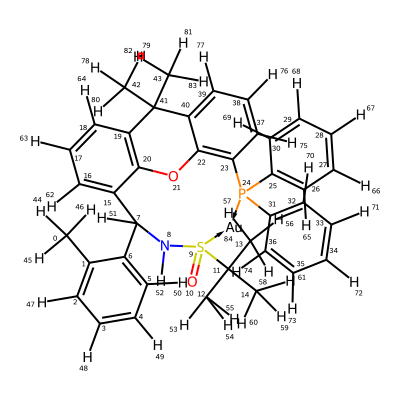

In [37]:
cat_mol

In [36]:
cat_smi

'Cc1ccccc1C1N[S](=O)(->[Au]<-[P](c2ccccc2)(c2ccccc2)c2cccc3c2Oc2c1cccc2C3(C)C)C(C)(C)C'

### PHOX

In [38]:
phox_smarts_idx_map = {'P-[#6,#7]~[#6]-[C;H0]1=N[C,c][C,c]O1':[0,4]}

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in phox_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = phox_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P','N']:
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                                    })

np.save("../dataset/processed/phox_complex.npy",cat_dataset)

100%|██████████| 12797/12797 [00:03<00:00, 3316.34it/s]


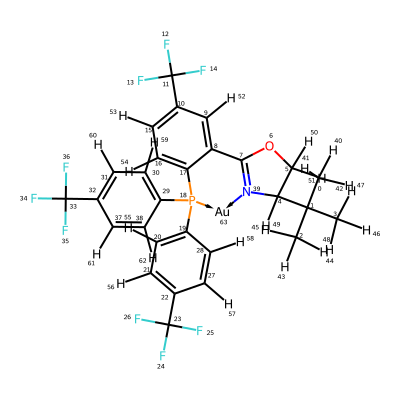

In [39]:
cat_mol

In [40]:
cat_smi

'CC(C)(C)C1COC2c3cc(C(F)(F)F)ccc3[P](->[Au]<-[N]=21)(c1ccc(C(F)(F)F)cc1)c1ccc(C(F)(F)F)cc1'

### BOX

In [42]:
box_smarts_idx_map = {'O1[C,c][C,c]N=[C]1~[#6]~[C]2=N[C,c][C,c]O2':[3,7]}

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in box_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = box_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['N']:
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,})

np.save("../dataset/processed/box_complex.npy",cat_dataset)

100%|██████████| 12797/12797 [00:06<00:00, 2079.14it/s]


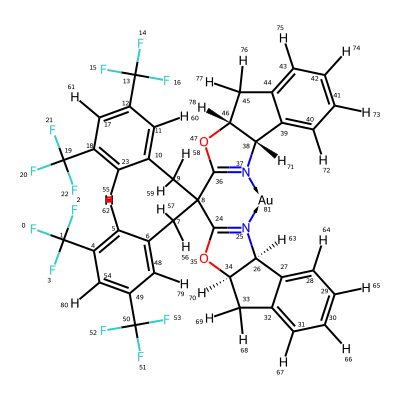

In [43]:
cat_mol

In [44]:
cat_smi

'FC(F)(F)c1cc(CC2(Cc3cc(C(F)(F)F)cc(C(F)(F)F)c3)C3=[N](->[Au]<-[N]4=C2O[C@@H]2Cc5ccccc5[C@@H]24)[C@H]2c4ccccc4C[C@H]2O3)cc(C(F)(F)F)c1'

### Salen

In [45]:
salen_smarts_idx_map = {'O-c1ccccc1-C=[N,n]~[#6]~[#6]~[N,n]=C-c2ccccc2O':[0,8,11,19]}

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in salen_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = salen_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['N','O']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                                    })

np.save("../dataset/processed/salen_complex.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:03<00:00, 3988.83it/s]


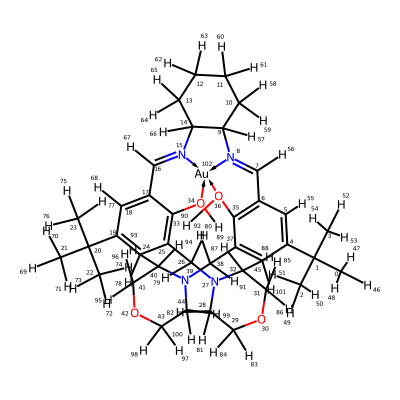

In [46]:
cat_mol

In [47]:
cat_smi

'CC(C)(C)c1cc2C=[N]3C4CCCCC4[N]4=Cc5cc(C(C)(C)C)cc(CN6CCOCC6)c5[OH]->[Au]<-3<-4<-[OH]c2c(CN2CCOCC2)c1'

### Bisphosphine

In [48]:
bisphos_smarts_idx_map = {'[P]~[#6,c]~[P]':[0,2],
 '[P]~[#6,c]~[#6,c]~[P]':[0,3],
 '[P]~[#6,c]~[#6,c]~[#6,c]~[P]':[0,4],
 '[P]~[#6,c]~[#6,c]~[#6,c]~[#6,c]~[P]':[0,5],
 'P-c1c2ccccc2ccc1-c3c(P)ccc4ccccc34':[0,13],
 'PC12C3C4C5C1[Fe]25436789C%10C6C7C8C%109P':[0,12],
 '[P;H0](-[#6])([-#6])-[#6]~[#6]~[P;H0](-[#6])-[#6]':[0,5],
 }


cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in bisphos_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = bisphos_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                                    })

np.save("../dataset/processed/bisphos_complex.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:08<00:00, 1580.55it/s]


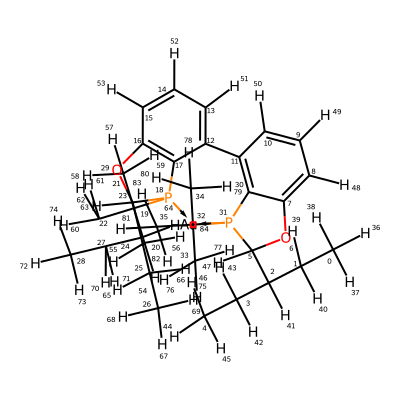

In [49]:
cat_mol

In [50]:
cat_smi

'CCC(CC)C1Oc2cccc3-c4cccc5c4[P](->[Au]<-[P]1(C(C)(C)C)c23)(C(C)(C)C)C(C(CC)CC)O5'

### NHC

In [121]:
nhc_smarts_idx_map = {'[n,N,n+,N+]1~[c,C;H1]~[n,N,n+,N+]~[c,C]~[c,C]1':[1]}
dehydrogen_rxn_template = "([n,N,n+,N+:1]1~[c,C;H1:2]~[n,N,n+,N+:3]~[c,C:4]~[c,C:5]1)>>([n,N:1]1~[c,C;H0:2]~[n,N:3]~[c,C:4]~[c,C:5]1)"
rxn = AllChem.ReactionFromSmarts(dehydrogen_rxn_template)
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in nhc_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = nhc_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['C']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                res_mol = rxn.RunReactants((Chem.RemoveHs(cat_mol),))[0][0]
                cat_smi = Chem.MolToSmiles(res_mol)
                if Chem.MolFromSmiles(cat_smi) is None:
                    continue
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles
                                    })

np.save("../dataset/processed/nhc_complex.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:05<00:00, 2425.32it/s]


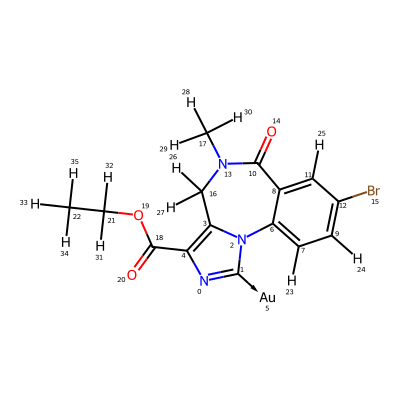

In [135]:
AllChem.AddHs(res_mol)

In [136]:
cat_smi

'CCOC(=O)c1n[c](->[Au])n2c1CN(C)C(=O)c1cc(Br)ccc1-2'

### Amino Acid

In [137]:
anion_amino_acid_idx_lst = [0,3]
neutral_amino_acid_smiles = '[N][CX4][C](=[O])[O;H1]'
anion_amino_acid_smarts = '[N][CX4][C](=[O])[O;H0-]'
dehydrogen_rxn_template = "[N:5][CX4:1][C:2](=[O:3])[O;H1:4]>>[N:5][CX4:1][C:2](=[O:3])[O-1:4]"
neutral_amino_acid_mol = Chem.MolFromSmarts(neutral_amino_acid_smiles)
anion_amino_acid_mol = Chem.MolFromSmarts(anion_amino_acid_smarts)
rxn = AllChem.ReactionFromSmarts(dehydrogen_rxn_template)

cat_dataset = []
cat_mol_lst = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    
    
    if mol.HasSubstructMatch(neutral_amino_acid_mol):
        pdt_mols = rxn.RunReactants((mol,))
        mol = pdt_mols[0][0]
    elif mol.HasSubstructMatch(anion_amino_acid_mol):
        mol = mol
    else:
        continue
    mol = Chem.AddHs(mol)
    match_at_idx_lst = mol.GetSubstructMatch(anion_amino_acid_mol)
    link_atom_idx = [match_at_idx_lst[idx] for idx in anion_amino_acid_idx_lst]
    check = True
    for atom_idx in link_atom_idx:
        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
        if atom_symbol not in ['N','O']:
            check = False
            print(123)
            break
    if not check:
        continue
    for metal in metal_lst:
        cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
        cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
        #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
        
        #if flag == 0:
        cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                            })
        cat_mol_lst.append(cat_mol)
    

np.save("../dataset/processed/amino_acid_complex.npy",cat_dataset) ###



100%|██████████| 12797/12797 [00:14<00:00, 903.93it/s]


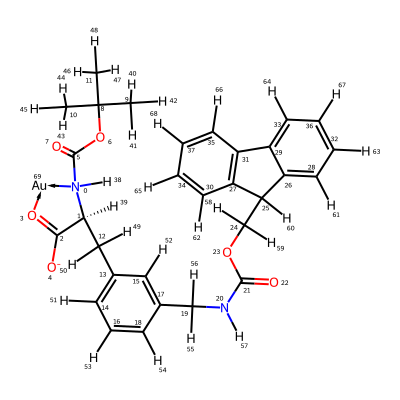

In [138]:
cat_mol

In [139]:
cat_smi

'CC(C)(C)OC(=O)[NH]1->[Au]<-[O]=C([O-])[C@@H]1Cc1cccc(CNC(=O)OCC2c3ccccc3-c3ccccc32)c1'

### N,N'-Dioxide

In [140]:
nn_dioxide_smarts_idx_map = {'[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]':[0,8,15,20],
                          '[O-][N+]1(CCC[N+]2([O-])CCCC2C=O)CCCC1C=O':[0,6,12,18]}

In [141]:
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in nn_dioxide_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = nn_dioxide_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['O']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                                    })

np.save("../dataset/processed/nn_dioxide_complex.npy",cat_dataset) ###


100%|██████████| 12797/12797 [00:04<00:00, 3054.54it/s]


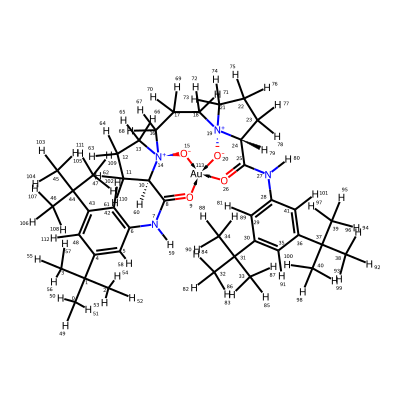

In [142]:
cat_mol

In [143]:
cat_smi

'CC(C)(C)c1cc(NC2=[O]->[Au]34<-[O]=C(Nc5cc(C(C)(C)C)cc(C(C)(C)C)c5)[C@H]5CCC[N@@+]5(CCC[N@@+]5([O-]->3)CCC[C@H]25)[O-]->4)cc(C(C)(C)C)c1'

### Monophosphine

In [144]:
monophos_smarts_idx_map = {'[P;X3;H0;v3;!$(P=[O,S,N])](-[#6,c])(-[#6,c])-[#6,c]':[0],
                          }
cat_dataset = []
cat_mols = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in monophos_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = monophos_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            if len(mol.GetSubstructMatches(smarts_mol)) > 1:
                continue
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,
                                    })
                cat_mols.append(cat_mol)


np.save("../dataset/processed/monophos_complex.npy",cat_dataset) ###


100%|██████████| 12797/12797 [00:31<00:00, 402.77it/s] 


In [146]:
cat_smi

'CC(=O)[O][Pd][c]1ccccc1-c1ccccc1[P](->[Au])(C(C)(C)C)C(C)(C)C'

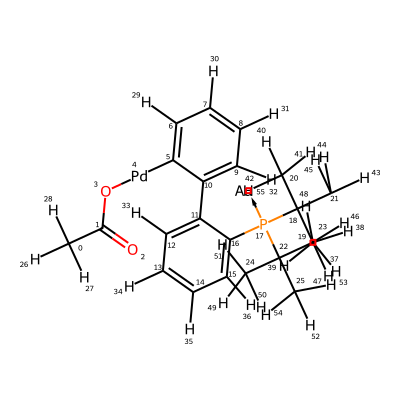

In [145]:
cat_mol

## 整合数据

In [147]:
data_files = sorted(glob.glob("../dataset/processed/*complex.npy") + ['../dataset/processed/original_smiles.npy'])
lig_cat_dataset = []
existed_smiles = []
for data_file in data_files:
    dataset = np.load(data_file,allow_pickle=True)
    if 'original_smiles' in data_file:
        dataset = dataset.item()
        for smiles in dataset:
            if smiles not in existed_smiles:
                existed_smiles.append(smiles)
                lig_cat_dataset.append({"smiles":smiles})
    else:
        for data in dataset:
            if data["cat_smiles"] not in existed_smiles:
                existed_smiles.append(data["cat_smiles"])
                lig_cat_dataset.append({"smiles":data["cat_smiles"]})

In [148]:
len(lig_cat_dataset)

207617

In [150]:
lig_cat_dataset[1000]

{'smiles': 'O=C1CC[C@@H]2C([O-])=[O]->[Ag]<-[NH]12'}

In [ ]:
np.save("../dataset/processed/lig_cat_dataset.npy",lig_cat_dataset)

## 构造新的CatDataset

### 先构造新的npy数据集文件

In [15]:
xtbopt_files = glob.glob("../dataset/processed/xtb_opt/*/xtbopt.xyz")
xtbopt_files = sorted(xtbopt_files,key=lambda x:int(x.split("/")[-2]))
print(f"There are {len(xtbopt_files)} xtbopt files")

There are 178674 xtbopt files


In [16]:
smiles_xtbopt_geom_info = []
for xtbopt_file in tqdm(xtbopt_files):
    dirname = os.path.dirname(xtbopt_file)
    init_file = f"{dirname}/{dirname.split('/')[-1]}.xyz"
    with open(init_file,"r") as fr:
        lines = fr.readlines()
    mol_inf = lines[1].strip()
    smiles = mol_inf.split()[1]
    with open(xtbopt_file,"r") as fr:
        lines = fr.readlines()
    coords = np.array([list(map(float,line.strip().split()[1:4])) for line in lines[2:]])
    atoms = [pt.GetAtomicNumber(line.strip().split()[0]) for line in lines[2:]]
    energy = float(lines[1].strip().split()[1])
    smiles_xtbopt_geom_info.append({"smiles":smiles,"atoms":atoms,"xtbopt_coords":coords,"xtb_energy":energy})
    
np.save(f"../dataset/processed/lig_cat_dataset_xtbopt_{len(smiles_xtbopt_geom_info)}.npy", smiles_xtbopt_geom_info)

100%|██████████| 178674/178674 [11:21<00:00, 262.26it/s]


In [17]:
len(smiles_xtbopt_geom_info)

178674

In [3]:
dataset = np.load("../dataset/processed/lig_cat_dataset.npy",allow_pickle=True)

In [45]:
dataset[0]

{'smiles': '[O-]C1=[O]->[Mg]<-[NH]2CSC[C@@H]12'}